# Convolutional Neural Networks: Step by Step

Implement convolutional and pooling layers in numpy

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

# 1 - Outline of the Assignment

![image](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gdr7xpxomsj20xk0bejtc.jpg)

```html
Convolution functions, including:
    Zero Padding
    Convolve window
    Convolution forward
    Convolution backward (optional)

Pooling functions, including:
    Pooling forward
    Create mask
    Distribute value
    Pooling backward (optional)
```

# 2 - Convolutional Neural Networks

![image](https://wx4.sinaimg.cn/mw690/701c57e5gy1gdrb9jlb1wj20qe0d63z3.jpg)

## 2.1 - Zero Padding

Add zeros around the border of an image
![image](https://wx1.sinaimg.cn/mw690/701c57e5gy1gdrb9kp5mhj20vw0qan55.jpg)


Benefits:
- use a CONV Layer **without shrinking** the height and width
- **keep more information at the border** of an image

Exercise:
- [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)


In [4]:
a = np.ones(shape = (1, 1))
print(a)

# (0, 3)上不补, 下补3个
# (2, 1)左补2个, 右补1个
print(np.pad(a, ((0, 3), (2, 1)), 'constant', constant_values = 0))

[[1.]]
[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [5]:
def zero_pad (X, padding):
    # X.shape = (m, n_H, n_W, n_C)
    """
    eg:
    X.shape = 3 * 3
    padding = 1
    X_padding = (3 + 2) * (3 + 2) = 5 * 5
    """
    pad_width = ((0, 0), (padding, padding), (padding, padding), (0, 0))
    return np.pad(X, pad_width, 'constant', constant_values = 0)

X.shape:  (4, 3, 3, 2)
X_pad.shape:  (4, 5, 5, 2)


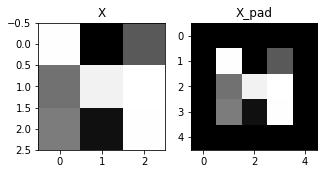

In [6]:
np.random.seed(1)
X = np.random.rand(4, 3, 3, 2)
X_pad = zero_pad(X, 1)
print('X.shape: ', X.shape)
print('X_pad.shape: ', X_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('X')
axarr[0].imshow(X[0,:,:,0])
axarr[1].set_title('X_pad')
axarr[1].imshow(X_pad[0,:,:,0])

In [11]:
print(np.ones(shape = (3, 2)))
print('======')
print(np.ones(shape = (3, 2, 4)))
print('======')
print(np.ones(shape = (3, 2, 4, 5)))

[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]


 [[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]


 [[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]

  [[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]]


## 2.2 - Single step of convolution

![image](https://wx3.sinaimg.cn/large/701c57e5gy1gdrb9k3i2qg20em0aojsv.gif)

* Weights = Filter: 3 * 3
* a_slice_prev: 图片的某个3 * 3 区域


```python
np.sum(a_slice_prev * Weights + bias)
```

In [73]:
def conv_single_step (a_slice_prev, W, b):
    # s = 对应位置相乘 + b
    s = a_slice_prev * W + b
    Z = np.sum(s)
    return Z

np.random.seed(1)

a_slice_prev = np.random.rand(3, 3, 3)
W = np.random.randn(3, 3, 3) # Filter_size * Filter_numbers
b = np.random.randn(1, 1, 1)

print('Z:', conv_single_step (a_slice_prev, W, b))

Z: -4.051739542293802


## 2.3 - Forward Pass

$A[0:2, 0:2, :]$

$A[x, y, z]$
* x取0,1位置
* y取0,1位置
* z取全部

![image](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gds525jgrsj20s80ks76f.jpg)

* `f: filter = weights`: 权重 / 过滤器 (找到图像edge)
* `s: stride`: 移动步长
* `p: padding`: zero padding in corner of an image
* `n_C = number of filters you use`

最后输出的图像尺寸
$$n_H = \frac{n_{Hprev} + 2 * p - f}{s} + 1$$
$$n_W = \frac{n_{Wprev} + 2 * p - f}{s} + 1$$
$$n_C$$

![image](https://wx4.sinaimg.cn/mw1024/701c57e5ly1gdq7c03q5lj216m0nkdx7.jpg)
- 一个filter是 $f * f * n_c^{[l - 1]}$
- 本层有$n_c^{[l]}$, filter 尺寸 * 数量 = $f * f * n_c^{[l - 1]} * n_c^{[l]}$

![image](https://wx3.sinaimg.cn/mw1024/701c57e5gy1gds5267mvej21g00u0n3f.jpg)

![image](https://wx3.sinaimg.cn/mw1024/701c57e5gy1gds525zf6uj219o0swwj0.jpg)

![image](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gduu5p7519j21hg0u0tc7.jpg)

![image](https://wx2.sinaimg.cn/mw1024/701c57e5gy1gduu5qm3c8j21pi0qs774.jpg)

In [49]:
def conv_forward_propagation (A_prev, W, b, hyperparameters):
    # 1. SIZE OF A_prev & Weights & bias
    # m samples, n_H列, h_W横, h_C深度(RGB)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # (10 4 4 3)
    
    # filters = weights n_f = filter numbers
    (f, f, n_C_prev, filter_num) = W.shape # (2 2 3 8)
    
    # 2. hyperparameters
    padding = hyperparameters['padding']
    stride = hyperparameters['stride']
    
    # 3. pad A_prev
    pad_width = ((0, 0), (padding, padding), (padding, padding), (0, 0))
    A_prev_pad = np.pad(A_prev, pad_width, 'constant', constant_values = 0)
    
    # 4. size of Z
    n_H = int((n_H_prev + 2 * padding - f) / stride) + 1
    n_W = int((n_W_prev + 2 * padding - f) / stride) + 1
    Z_OUTPUT = np.ones(shape = (m, n_H, n_W, filter_num)) # (10, 7, 7, 8)
    
    # 5. compute
    # 5.1 - samples
    for _m in range(m):
        # 第_m个样本值
        X = A_prev_pad[_m]
        # 5.2 - 列
        for i in range(n_H_prev):
            # 5.3 - 行
            for j in range(n_W_prev):
                # 5.4 - 深度 (filter的数量)
                for depth in range(filter_num):
                    # 5.5 - 一块filter计算 (第depth块filter)
                    """
                    print((start_w, end_w), (start_h, end_h))
                    从0,1列固定, 行扫描
                    (0, 2) (0, 2)
                    (1, 3) (0, 2)
                    (2, 4) (0, 2)
                    (3, 5) (0, 2)
                    从1,2列固定, 行扫描
                    (0, 2) (1, 3)
                    (1, 3) (1, 3)
                    ...
                    """
                    start_w = stride * j
                    end_w = stride * j + f
                    start_h = stride * i
                    end_h = stride * i + f

                    # 一个filter需要匹配的 X_slice = (2, 2, 3), 我们有 filter数量 filter_num, 要依次计算的
                    X_slice = X[start_h: end_h, start_w: end_w, :] # (2, 2, 3)
                    W_slice = W[:, :, :, depth] # (2, 2, 3)
                    b_slice = b[:, :, :, depth] # (2, 2, 3)
                    
                    Z_slice = np.sum(X_slice * W_slice + b_slice)
                    
                    Z_OUTPUT[_m, i, j, depth] = Z_slice
                    """
                    print((_m, i, j, depth), Z_slice)
                    (0, 0, 0, 0) 14.637002967727645
                    (0, 0, 0, 1) 12.599114715055327
                    (0, 0, 0, 2) 10.89524535267526
                    (0, 0, 0, 3) -6.533884919403175
                    (0, 0, 0, 4) 4.00214921646181
                    (0, 0, 0, 5) -1.457516900893595
                    (0, 0, 0, 6) -13.450511821222593
                    (0, 0, 0, 7) -4.907759904619583
                    (0, 0, 1, 0) 14.637002967727645
                    (0, 0, 1, 1) 12.599114715055327
                    (0, 0, 1, 2) 10.89524535267526
                    (0, 0, 1, 3) -6.533884919403175
                    (0, 0, 1, 4) 4.00214921646181
                    (0, 0, 1, 5) -1.457516900893595
                    (0, 0, 1, 6) -13.450511821222593
                    (0, 0, 1, 7) -4.907759904619583
                    (0, 0, 2, 0) 14.637002967727645
                    (0, 0, 2, 1) 12.599114715055327
                    ....
                    """
    return Z_OUTPUT
                    

In [52]:
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hyperparameters = {"padding" : 2, "stride": 1}

Z_OUTPUT = conv_forward_propagation (A_prev, W, b, hyperparameters)
print(Z_OUTPUT.shape)

(10, 7, 7, 8)


## 2. 3 - Forward Pooling

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

![image](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Convolutional%20Neural%20Networks/images/max_pool1.png)

In [70]:
def pool_forward (A_prev, hyperparameters, mode = 'max'):
    # A_prev
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # hyperparameters
    f = hyperparameters['filter'] # f * f * n_C_prev
    s = hyperparameters['stride']

    # output_size
    n_H = int((n_H_prev - f) / s) + 1
    n_W = int((n_W_prev - f) / s) + 1
    n_C = n_C_prev
    
    Z_OUTPUT = np.zeros(shape = (m, n_H, n_W, n_C)) # (1 2 2 3)
    
    # 1. samples
    for _m in range(m):
        X = A_prev[_m] # (4, 4, 3)
        # 2. 列
        for i in range(n_H):
            # 3. 行
            for j in range(n_W):
                # 4. 深度
                for depth in range(n_C):
                    # 5. 位置 (列, 行, 深度)
                    start_h = i * s
                    end_h = i * s + f
                    start_w = j * s
                    end_w = j * s + f

                    X_slice = X[start_h: end_h, start_w: end_w, depth] # 2 * 2
                    max_slice = np.max(X_slice)
                    Z_OUTPUT[_m, i, j, depth] = max_slice
                    """
                    print(_m, i, j, depth)
                    长宽都先固定好, then 遍历深度
                    === filter_num = 3 start ===
                    0 0 0 0
                    0 0 0 1
                    0 0 0 2
                    === filter_num = 3 end ===
                    移到下一个位置, 长宽都先固定好, then 遍历深度
                    0 0 1 0
                    0 0 1 1
                    0 0 1 2
                    0 1 0 0
                    0 1 0 1
                    0 1 0 2
                    0 1 1 0
                    0 1 1 1
                    0 1 1 2
                    """
    return Z_OUTPUT

In [73]:
np.random.seed(1)
A_prev = np.random.randn(1, 4, 4, 3)
hyperparameters = {'stride': 2, 'filter': 2}

Z_After_Pool = pool_forward (A_prev, hyperparameters, mode = 'max')
print('After Pool.....', Z_After_Pool)

After Pool..... [[[[ 1.62434536  0.86540763  1.13376944]
   [ 1.74481176  1.46210794  0.50249434]]

  [[ 0.90085595  0.2344157   1.65980218]
   [-0.63699565  1.6924546   2.10025514]]]]
